In [ ]:
!pip install -q gradio

## Serverless Inference

Head to Hugging Face Tokens for your school: https://huggingface.co/organizations/ESCP/settings/tokens ➡️ Select "Create New Token" ➡️ "Read Access"

⬅️ From left sidebar on Colab, click on "🔑" Select "Add new secret", add the token with the name "HF_TOKEN".

Restart runtime.

**Text Generation**

In [1]:
from google.colab import userdata
token = userdata.get('HF_TOKEN')

In [2]:
import os
from huggingface_hub import InferenceClient

client = InferenceClient(
    provider="auto",
    api_key=token,
)

completion = client.chat.completions.create(
    model="deepseek-ai/DeepSeek-V3.2-Exp",
    messages=[
        {
            "role": "user",
            "content": "What is the capital of France?"
        }
    ],
)

print(completion.choices[0].message)

ChatCompletionOutputMessage(role='assistant', content='The capital of France is **Paris**.', reasoning=None, tool_call_id=None, tool_calls=None)


**Multimodal Generation**

In [3]:
import os
from huggingface_hub import InferenceClient

client = InferenceClient(
    provider="auto",
    api_key=token,
)

completion = client.chat.completions.create(
    model="Qwen/Qwen3-VL-235B-A22B-Instruct",
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "Describe this image in one sentence."
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": "https://huggingface.co/datasets/merve/vlm_test_images/resolve/main/venice.jpg"
                    }
                }
            ]
        }
    ],
)

print(completion.choices[0].message)

ChatCompletionOutputMessage(role='assistant', content='A seagull perches on a wooden post in the foreground of a Venetian canal, with the ornate facade of the Church of San Geremia, a water bus, gondolas, and a stone bridge visible under a clear blue sky.', reasoning=None, tool_call_id=None, tool_calls=None)


**Image Generation**

In [6]:
import os
from huggingface_hub import InferenceClient

client = InferenceClient(
    provider="auto",
    api_key=token,
)

# output is a PIL.Image object
image = client.text_to_image(
    "Astronaut riding a horse on the moon",
    model="black-forest-labs/FLUX.1-dev",
)

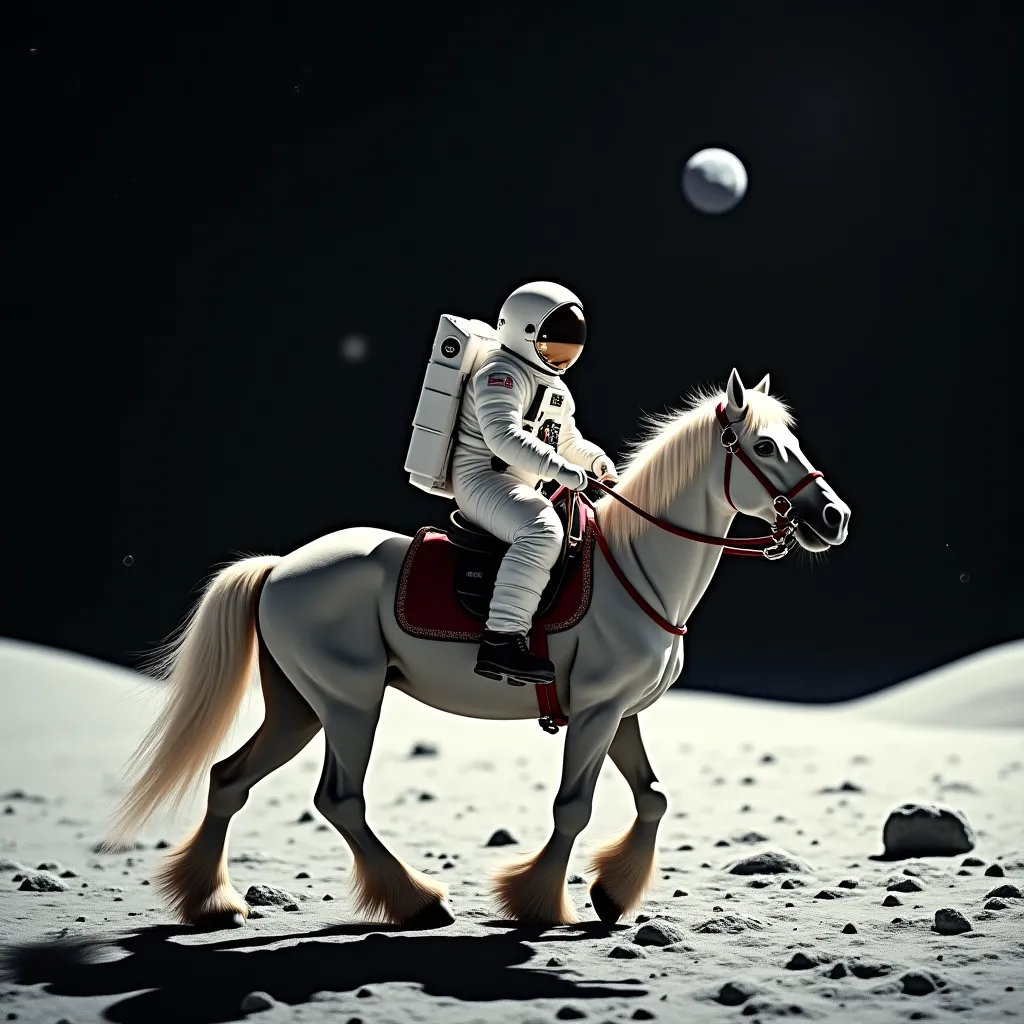

In [7]:
image

## Local Transformers Inference

In [10]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-generation", model="HuggingFaceTB/SmolLM2-135M-Instruct")
messages = [
    {"role": "user", "content": "What is the capital of France called?"},
]
pipe(messages)

Device set to use cuda:0


[{'generated_text': [{'role': 'user',
    'content': 'What is the capital of France called?'},
   {'role': 'assistant',
    'content': 'The capital of France is Paris, a city known for its historical landmarks, cultural institutions, and cultural festivals.'}]}]

Optional for folks with technical background, bare model inference:

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM2-135M-Instruct")
model = AutoModelForCausalLM.from_pretrained("HuggingFaceTB/SmolLM2-135M-Instruct")
messages = [
    {"role": "user", "content": "Who are you?"},
]

inputs = tokenizer.apply_chat_template(
	messages,
	add_generation_prompt=True,
	tokenize=True,
	return_dict=True,
	return_tensors="pt",
).to(model.device)

outputs = model.generate(**inputs, max_new_tokens=40)
print(tokenizer.decode(outputs[0][inputs["input_ids"].shape[-1]:]))

In [11]:
del pipe

You can also do many other tasks! Such as **object detection**.

In [14]:
from transformers import pipeline

detector = pipeline(model="facebook/detr-resnet-50")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Device set to use cuda:0


![](https://huggingface.co/datasets/Narsil/image_dummy/raw/main/parrots.png)

In [15]:
detector("https://huggingface.co/datasets/Narsil/image_dummy/raw/main/parrots.png")

[{'score': 0.9966394901275635,
  'label': 'bird',
  'box': {'xmin': 69, 'ymin': 171, 'xmax': 396, 'ymax': 507}},
 {'score': 0.999381422996521,
  'label': 'bird',
  'box': {'xmin': 398, 'ymin': 105, 'xmax': 767, 'ymax': 507}}]

Check out all the pipelines here: https://huggingface.co/docs/transformers/en/main_classes/pipelines

## Building our first app with Gradio

Let's build a text generation app with Gradio.

In [16]:
import gradio as gr
from transformers import pipeline
#import spaces

pipe = pipeline("text-generation", model="HuggingFaceTB/SmolLM2-135M-Instruct")

#@spaces.GPU()
def chat_fn(user_message):
    messages = [{"role": "user", "content": user_message}]
    response = pipe(messages)
    return response[0]["generated_text"]

demo = gr.Interface(
    fn=chat_fn,
    inputs=gr.Textbox(label="Your message", placeholder="Ask me anything", lines=3),
    outputs=gr.Textbox(label="Model response"),
    title="💬 SmolLM2 Chat",
    description="Chat app powered by SmolLM2-135M-Instruct"
)

if __name__ == "__main__":
    demo.launch()


Device set to use cuda:0


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b92c11b1cffdf69a03.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


To deploy this:

➡️ go to hf.co/new-space

➡️ give a name to your Space, select "ZeroGPU" in Space Hardware

➡️ put the above code to "app.py" file

➡️ add libraries used in this project (transformers, spaces) to "requirements.txt" file

➡️ upload both app.py file and requirements.txt file to your Space

See the app here: https://huggingface.co/spaces/merve/dummy-app